In [1]:
# Initial setup of copula generative model based on parametric distributions for larger set of variables
# Extension to parametric design context
#
# Author: Alex Braafladt
#
# Version: v1 Initial creation 3/11/2022
#          v2 First draft with all components for nonparametric experiment for continuous case 3/14/2022
#          v3 Draft with updates for hosting on GitHub 5/2/2022
#
# References:
#   -https://openturns.github.io/openturns/latest/theory/probabilistic_modeling/copulas.html#copula
#   -https://openturns.github.io/openturns/latest/auto_probabilistic_modeling/copulas/plot_composed_copula.html
#   -https://en.wikipedia.org/wiki/Copula_(probability_theory)

# Parametric order reduction with emulator data

Extension of order reduction approach to design context with parametricly varying input variables. Structured OR approach tested with hypothesis of using empirical probability density functions, and falsified, prompting an alternative hypothesis

In [2]:
# probabilistic and statistical modeling
import openturns as ot
import openturns.viewer as viewer
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats as st
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon

# data and numerical functions
import numpy as np
import pandas as pd

# graphing and visualization functions
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import AnchoredText

# order reduction and data conditioners
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split

# design of experiments
from doepy import build

# os operations
import os as os
import sys
import datetime as dt
import pickle
from joblib import dump, load

# custom functions
import stats_functions as sf
import copula_gen_data as cpgen
from emulator_classes import Simulation, Data, Experiment, Analysis

In [3]:
# directory setup

# get current working directory
wrkdir = os.getcwd()
print('Current working directory: '+wrkdir)
# set up a data save directory for all future runs
newoutputdir = wrkdir+'\output'
if not os.path.exists(newoutputdir):
    os.makedirs(newoutputdir)
# set up a new directory to store files for the current run - updates at each new full run of notebook
curDatetime = dt.datetime.now()
datasavedir = newoutputdir + r'\\' + 'parOR' + str(curDatetime.strftime('%Y%m%d%H%M%S'))
if not os.path.exists(datasavedir):
    os.makedirs(datasavedir)
print('Data save directory: '+datasavedir)

Current working directory: C:\Users\alexb\PycharmProjects\distribution-surrogates
Data save directory: C:\Users\alexb\PycharmProjects\distribution-surrogates\output\\parOR20220603110211


In [4]:
%%time
# generate parametric data
input_ranges = np.array([[500.0, 55000.0], [100.0, 7000.0], [-5.0,3.0], [0.1, 0.9], [0.0, 0.5],
                         [40.0, 80.0], [0.5, 1.5], [1.0, 4.0], [0.5, 1.5], [2.0, 3.0],
                         [0.2, 0.8], [0.4, 0.8], [1., 15.], [7., 10.], [1., 10.]])

# flag which distributions are discrete for later use in analysis
discrete_flags = []
for i in range(25):
    discrete_flags.append(False)
for i in range(5):
    discrete_flags.append(True)

parametric_experiment = Experiment(input_ranges, num_cases=1000, discrete_flags=discrete_flags)
parametric_experiment.generate_data()
exp_data = parametric_experiment.data

CPU times: total: 2min 50s
Wall time: 36.8 s


#### Attempt at order reduction with parametric data
In the parametric case, the data is instead stacked into snapshots to identify a basis for the **set** of distributions generated by each simulation run. However, the histogram structuring approach runs into a problem here which will be shown below.

In [5]:
# show error that results from histogram structuring approach

# structuring data across all cases ranges for the histogram bins
# get full set bins
raw_data = exp_data.scaled_samples
split_data_by_case = np.split(raw_data, raw_data.shape[0], axis=0)
split_data_by_case = [elem[0] for elem in split_data_by_case]
data_np_dists = np.concatenate(split_data_by_case, axis=0)
def get_global_bins(arr):
    _, bins = np.histogram(arr,bins=50)
    return bins
epdf_global_bins = np.apply_along_axis(get_global_bins, arr=data_np_dists, axis=0)
epdf_global_bins = np.split(epdf_global_bins, epdf_global_bins.shape[1], axis=1)
# structure data accordingly
split_data_by_dist = np.split(raw_data, raw_data.shape[2], axis=2)
split_data_by_dist = [elem[:,:,0] for elem in split_data_by_dist]
# pair bins and data
paired_data = list(zip(epdf_global_bins, split_data_by_dist))
# structure data
# structured_data = [sf.get_epdf_probs(t[1][:,0], t[0][:,0]) for t in paired_data]
structured_data = [np.apply_along_axis(sf.get_epdf_probs, arr=t[1], bins=t[0][:,0], axis=1) for t in paired_data]
structured_data = np.stack(structured_data, axis=2)

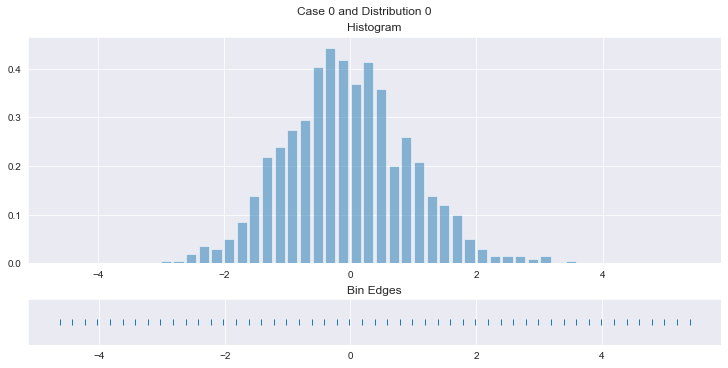

In [6]:
# plot case with where structuring works as desired
case_to_plot = 0
dist_to_plot = 0
title = "Case " + str(case_to_plot) + " and Distribution " + str(dist_to_plot)
# plot example of epdf structure
fig1, ax1 = plt.subplots(2,1, figsize=(10,5), constrained_layout=True, gridspec_kw={'height_ratios':[5,1]})
ax = ax1.ravel()
center = ( (epdf_global_bins[dist_to_plot][:-1] + epdf_global_bins[dist_to_plot][1:])/2.0 )[:,0]
width = (epdf_global_bins[dist_to_plot][1] - epdf_global_bins[dist_to_plot][0])*0.8
ax[0].bar(center, structured_data[case_to_plot,:,dist_to_plot], alpha=0.5, width=width, label='Probabilities in bins')
ax[0].set_title("Histogram")
ax[1].plot(epdf_global_bins[dist_to_plot], np.zeros_like(epdf_global_bins[dist_to_plot]), '|', label='Bin edges')
ax[1].set_title('Bin Edges')
ax[1].set_yticks(())
plt.suptitle(title)
plot_title = 'Case ' + str(case_to_plot) + ' Distribution ' + str(dist_to_plot) + ' Histogram-Bin-Comparison'
fig1.savefig(datasavedir + '/' + plot_title + '.png')

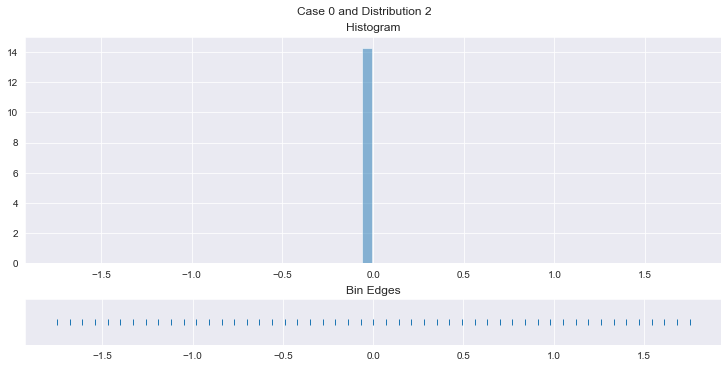

In [7]:
# plot case with resolution difficulty
case_to_plot = 0
dist_to_plot = 2
title = "Case " + str(case_to_plot) + " and Distribution " + str(dist_to_plot)
# plot example of epdf structure
fig2, ax2 = plt.subplots(2,1, figsize=(10,5), constrained_layout=True, gridspec_kw={'height_ratios':[5,1]})
ax = ax2.ravel()
center = ( (epdf_global_bins[dist_to_plot][:-1] + epdf_global_bins[dist_to_plot][1:])/2.0 )[:,0]
width = (epdf_global_bins[dist_to_plot][1] - epdf_global_bins[dist_to_plot][0])*0.8
ax[0].bar(center, structured_data[case_to_plot,:,dist_to_plot], alpha=0.5, width=width, label='Probabilities in bins')
ax[0].set_title("Histogram")
ax[1].plot(epdf_global_bins[dist_to_plot], np.zeros_like(epdf_global_bins[dist_to_plot]), '|', label='Bin edges')
ax[1].set_title('Bin Edges')
ax[1].set_yticks(())
plt.suptitle(title)
plot_title = 'Case ' + str(case_to_plot) + ' Distribution ' + str(dist_to_plot) + ' Histogram-Bin-Comparison'
fig2.savefig(datasavedir + '/' + plot_title + '.png')

In [8]:
#todo - add Bokeh interactive plot

#### Falsified hypothesis 1
The structuring approach that formed a part of the hypothesis for working effectively order reduction was based on defining the histogram bins based on the full training dataset (so as to be able to recover those bins for any interpolated distribution). However, this leads to cases where the resolution of the histograms is lost when there is enough mean shift across the cases in the dataset. Having falsified this hypothesis, an alternative hypothesis is generated and considered next.

## Alternative hypothesis 1
A set of alternatives were generated as options to enable the feasibility of order reduction with the stochastic distributions after falsifying the original approach. Please reach out to request the details if desired, but the most promising alternative was structuring using empirical cumulative distribution functions (ecdfs). This separates the structure into two components, the x-values of the ecdf, and y-values that depend solely on the number of samples included in the data used to generate the ecdf. This separation allows the only piece of information needed in the modeling process to be the ecdf x-values.

In [9]:
# alternative hypothesis with ecdf structuring approach

# structuring data across all cases based on ecdfs
ecdf_y, ecdfx_true = exp_data.scaled_ecdfs

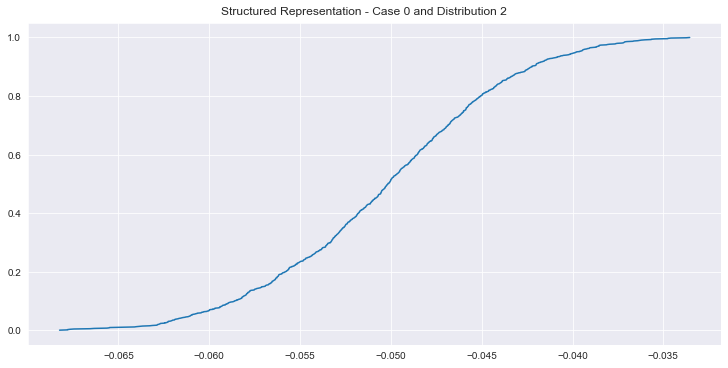

In [10]:
# plot case example
case_to_plot = 0
dist_to_plot = 2
title = "Structured Representation - Case " + str(case_to_plot) + " and Distribution " + str(dist_to_plot)
# plot example of epdf structure
fig3, ax3 = plt.subplots(1,1, figsize=(10,5), constrained_layout=True)
ax3.plot(ecdfx_true[case_to_plot,:,dist_to_plot], ecdf_y)
plt.suptitle(title)
fig3.savefig(datasavedir + '/' + title + '.png')

#### Set up the PCA model
The PCA model (using sklearn) is set up by learning (with PCA) the latent space basis corresponding to the required relative information content retained in the data.

In [11]:
# sweep through OR RIC levels with data to show performance of approach

# define the OR properties
req_ric = 0.9999
pca = PCA(req_ric)

# set up data for OR
data_for_pca = cpgen.pca_stack(ecdfx_true)

# run the OR
pca.fit(data_for_pca)
print('Number of components needed for retaining ', req_ric, ' RIC: ', pca.n_components_, ' of ', data_for_pca.shape[1])

Number of components needed for retaining  0.9999  RIC:  686  of  1000


#### Transform the data using the PCA OR model
Transform the data into the truncated latent space and then back out using the inverse transform. This results in approximate data with losses based on the direct mapping into and out of a reduced subspace.

In [12]:
%%time
# transform the data based on PCA
latent_data = pca.transform(data_for_pca)
ecdfx_approx = cpgen.pca_destack(pca.inverse_transform(latent_data), ecdfx_true.shape[1], ecdfx_true.shape[2])

or_model_data = Data(ecdf_vals=(ecdf_y, ecdfx_approx),
                     discrete_flags=exp_data.discrete_flags,
                     scaler=exp_data.scaler,
                     custom_bins=exp_data.custom_bins)
or_model_data.data_setup_from_ecdfs()

CPU times: total: 5min 58s
Wall time: 6min 2s


In [13]:
# get ecdf predictions
ecdf_y_, ecdfx_or = or_model_data.scaled_ecdfs

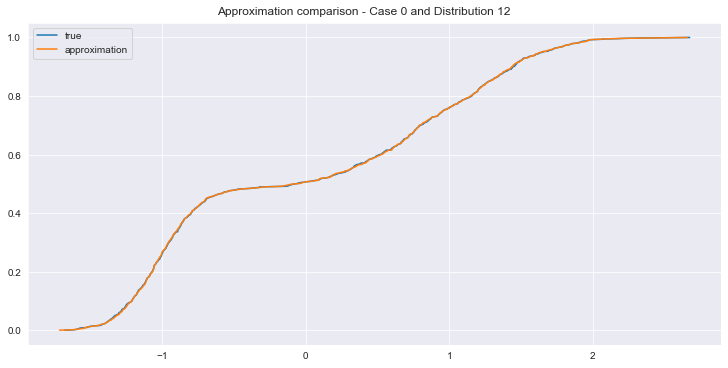

In [14]:
# plot one comparison
case_to_plot = 0
dist_to_plot = 12
title = "Approximation comparison - Case " + str(case_to_plot) + " and Distribution " + str(dist_to_plot)
# plot example of epdf structure
fig4, ax4 = plt.subplots(1,1, figsize=(10,5), constrained_layout=True)
ax4.plot(ecdfx_true[case_to_plot,:,dist_to_plot], ecdf_y, label='true')
ax4.plot(ecdfx_or[case_to_plot,:,dist_to_plot], ecdf_y, label='approximation')
ax4.legend()
plt.suptitle(title)
fig4.savefig(datasavedir + '/' + title + '.png')

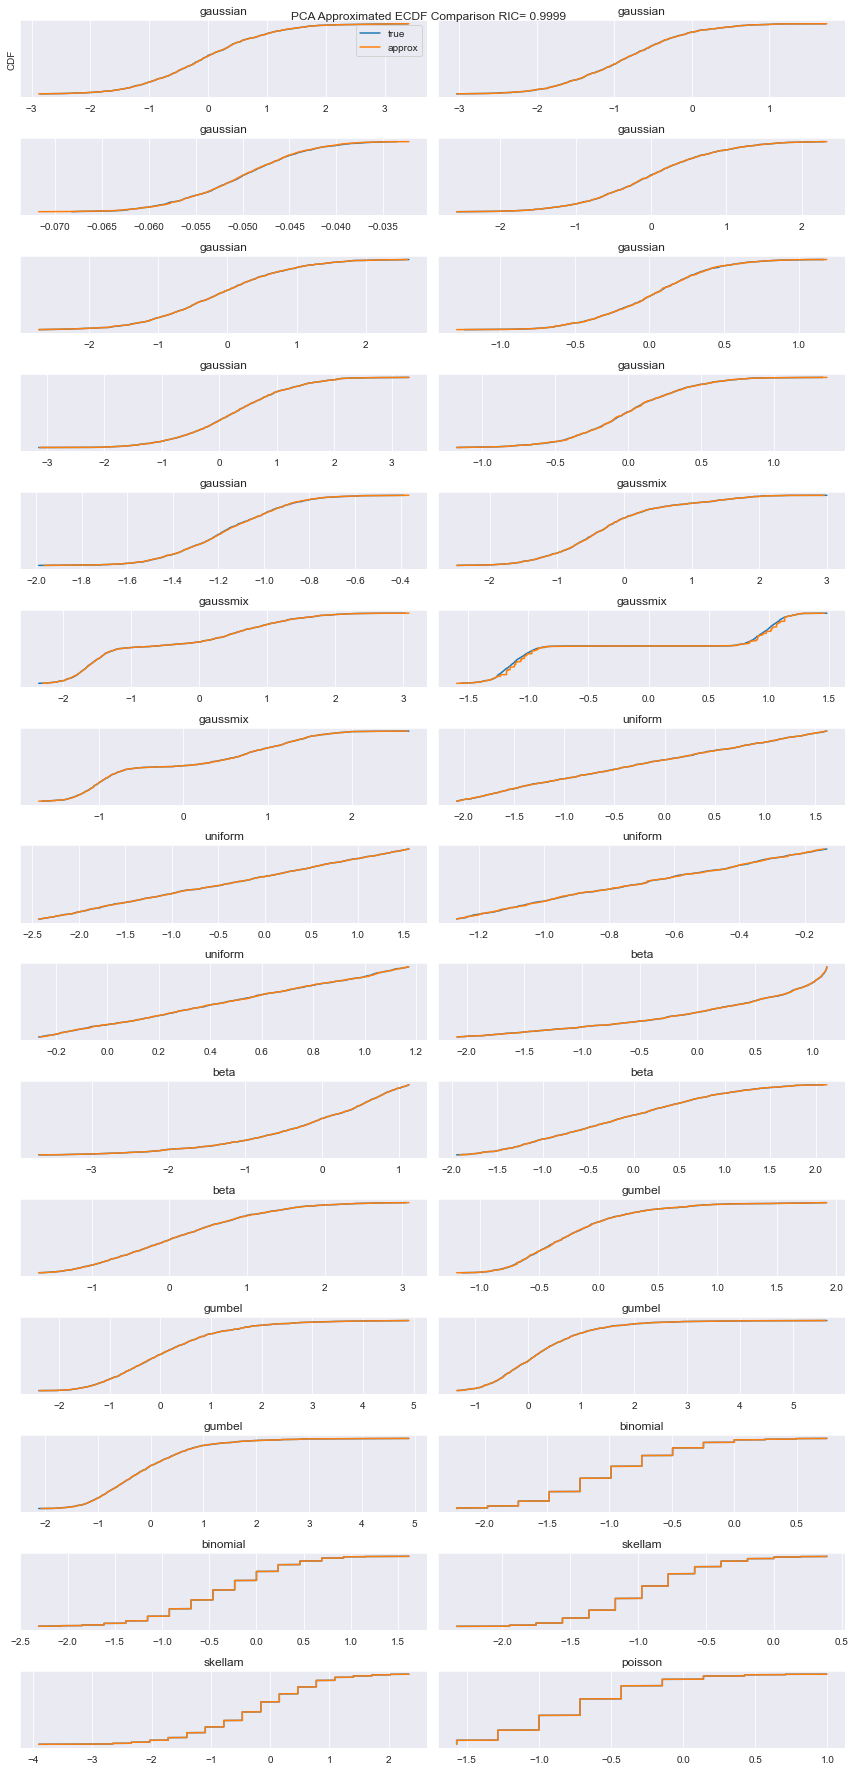

In [15]:
# plot a set of comparisons
case_to_plot = 0
fig5, ax5 = plt.subplots(15, 2, figsize=(12,25))
ax = ax5.ravel()
for i in range(30):
    ax[i].plot(ecdfx_true[case_to_plot,:,i], ecdf_y)
    ax[i].plot(ecdfx_or[case_to_plot,:,i], ecdf_y)
    ax[i].set_title(parametric_experiment.simulations[0].distribution_types[i])
    ax[i].set_yticks(())
ax[0].set_ylabel("CDF")
ax[0].legend(['true', 'approx'], loc='best')
fig5.suptitle('PCA Approximated ECDF Comparison RIC= '+str(req_ric))
fig5.tight_layout()
plot_title = 'Case ' + str(case_to_plot) + ' comparison for PCA Approximated ECDF Comparison RIC= '+str(req_ric)
fig5.savefig(datasavedir + '/' + plot_title + '.png')

#### Order reduction model goodness-of-fit
The basic performance of the structured modeling approach is baked into the RIC maintained, and is qualitatively shown in the comparison figures that can be interactively updated to look through all the training data above.

However, the statistical consistency also needs to meet reason-ability requirements in tandem with visual inspection. This is done here using a comparison to data which is from an additional independent sample from the simulations defined in the experiment.

In [16]:
%%time
# generate new data to work with
input_ranges = np.array([[500.0, 55000.0], [100.0, 7000.0], [-5.0,3.0], [0.1, 0.9], [0.0, 0.5],
                         [40.0, 80.0], [0.5, 1.5], [1.0, 4.0], [0.5, 1.5], [2.0, 3.0],
                         [0.2, 0.8], [0.4, 0.8], [1., 15.], [7., 10.], [1., 10.]])
# flag which distributions are discrete for later use in analysis
discrete_flags = []
for i in range(25):
    discrete_flags.append(False)
for i in range(5):
    discrete_flags.append(True)

# true data - original simulation setup
parametric_experiment = Experiment(input_ranges, num_cases=1000, discrete_flags=discrete_flags)
parametric_experiment.generate_data()
true_data = parametric_experiment.data

# comparison data - using same setup as original data
comparison_experiment = Experiment(input_ranges, num_cases=1000, discrete_flags=discrete_flags,
                                   custom_bins=true_data.scaled_epdfs[0], custom_doe=parametric_experiment.doe_table,
                                   custom_scaler=true_data.scaler)
comparison_experiment.generate_data()
comparison_data = comparison_experiment.data

Using custom DOE table
CPU times: total: 5min 45s
Wall time: 1min 6s


In [17]:
%%time
# define the OR properties
req_ric = None
pca = PCA(req_ric)

# set up data for OR
ecdf_y, ecdfx_true = true_data.scaled_ecdfs
data_for_pca = cpgen.pca_stack(ecdfx_true)

# run the OR
pca.fit(data_for_pca)
print('Number of components needed for retaining ', req_ric, ' RIC: ', pca.n_components_, ' of ', data_for_pca.shape[1])

# transform the data based on PCA
latent_data = pca.transform(data_for_pca)
ecdfx_approx = cpgen.pca_destack(pca.inverse_transform(latent_data), ecdfx_true.shape[1], ecdfx_true.shape[2])

or_model_data = Data(ecdf_vals=(ecdf_y, ecdfx_approx),
                     discrete_flags=true_data.discrete_flags,
                     scaler=true_data.scaler,
                     custom_bins=true_data.scaled_epdfs[0])
or_model_data.data_setup_from_ecdfs()

Number of components needed for retaining  None  RIC:  1000  of  1000
CPU times: total: 5min 44s
Wall time: 5min 17s


In [18]:
analysis = Analysis(true_data=true_data, model_data=or_model_data, comparison_data=comparison_data, cross_val_type='train')
analysis.calc_differencing_metrics()
test_df = analysis.get_differencing_df()
analysis.get_percent_reasonable()

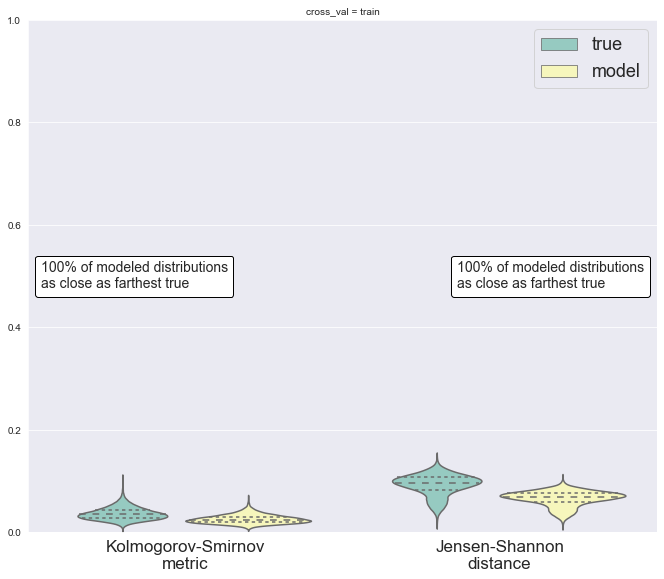

In [19]:
analysis.plot_single_stat_consistency_comparison()
plt.savefig(datasavedir + '/parametric_case_ecdf_or.png')

#### Order reduction based on varying RIC in PCA
A comparison of the statistical consistency of the approximate distributions based on a selection of RIC is needed to understand what level of reduction in the latent space is acceptable.

In [20]:
%%time
# sweep through RIC values to visualize statistical consistency and dimension reduction
rics = [0.9, 0.99, 0.999, 0.9999, None]
# set up pca models
pcas = [PCA(ric) for ric in rics]

# fit the pca models
pcas[:] = [model.fit(data_for_pca) for model in pcas]
for (model, ric) in zip(pcas, rics):
    print('Number of components needed for retaining ', ric, ' RIC: ', model.n_components_, ' of ', data_for_pca.shape[1])

Number of components needed for retaining  0.9  RIC:  7  of  1000
Number of components needed for retaining  0.99  RIC:  15  of  1000
Number of components needed for retaining  0.999  RIC:  168  of  1000
Number of components needed for retaining  0.9999  RIC:  687  of  1000
Number of components needed for retaining  None  RIC:  1000  of  1000
CPU times: total: 2min 5s
Wall time: 24.8 s


In [21]:
%%time
# create Data objects for each pca model
transformed_data = [model.transform(data_for_pca) for model in pcas]
formatted_data = [cpgen.pca_destack(model.inverse_transform(current_data),
                                    ecdfx_true.shape[1], ecdfx_true.shape[2]) for (model, current_data) in zip(pcas, transformed_data)]
pca_sweep_data = [Data(ecdf_vals=(ecdf_y, data_slice),
                     discrete_flags=true_data.discrete_flags,
                     scaler=true_data.scaler,
                     custom_bins=true_data.scaled_epdfs[0]) for data_slice in formatted_data]
for data_obj in pca_sweep_data:
    data_obj.data_setup_from_ecdfs()

CPU times: total: 25min 51s
Wall time: 25min 37s


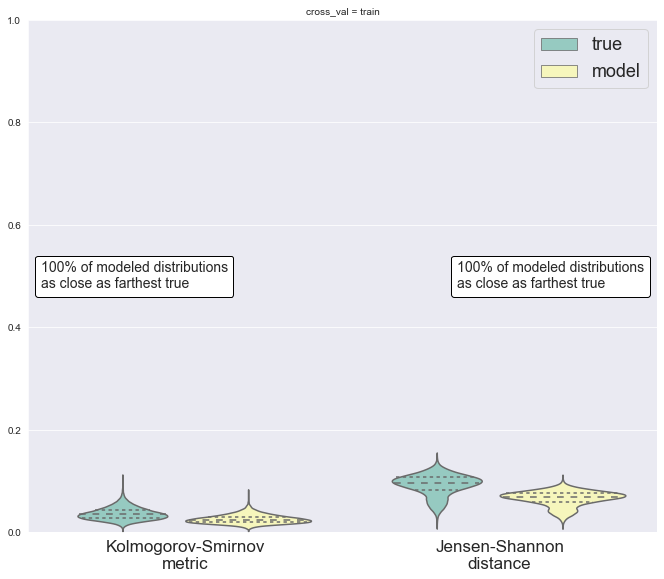

In [22]:
pca_sweep_analyses = [Analysis(true_data=true_data, model_data=mod_data,
                               comparison_data=comparison_data, cross_val_type='train') for mod_data in pca_sweep_data]
for obj in pca_sweep_analyses:
    obj.calc_differencing_metrics()
    _ = obj.get_differencing_df()
    obj.get_percent_reasonable()
obj.plot_single_stat_consistency_comparison()

In [23]:
# get dataframe with metrics from analysis objects
pca_sweep_dfs = [obj.get_differencing_df() for obj in pca_sweep_analyses]

updated_dfs = []
for (ric_id, df) in zip(rics, pca_sweep_dfs):
    if ric_id is None:
        true_df = df[(df['comparison'] == 'true')]
        model_df = df[(df['comparison'] == 'model')]
        model_df['comparison'] = 'full_model'
        model_df = pd.concat([true_df, model_df], axis=0)
    else:
        model_df = df[(df['comparison'] == 'model')]
        model_df['comparison'] = str(ric_id) + '_model'
    updated_dfs.append(model_df)
pca_sweep_final_df = pd.concat(updated_dfs, axis=0)

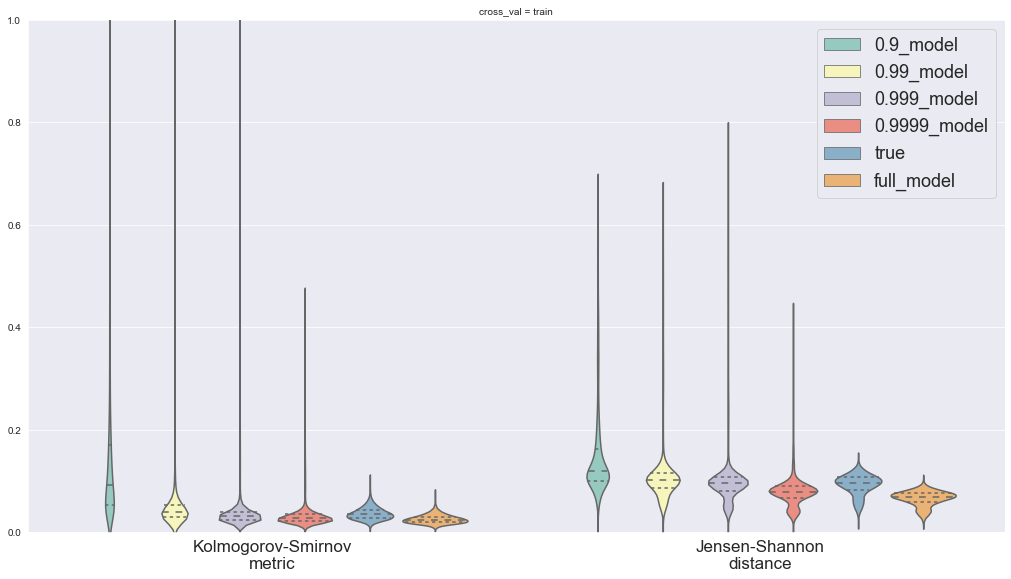

In [24]:
# define multi plotting function
def plot_multi_stat_consistency_comparison(df):
        """Plot the comparison of statistical consistency for KS and JS for one crossval type"""
        # main violin plots
        g = sns.catplot(data=df, x='test_type', y='metric', hue='comparison', palette='Set3',
                        height=8, aspect=1.8, inner='quartile', col='cross_val', kind='violin')
        (g.set_axis_labels("", "")
          .set_xticklabels(["Kolmogorov-Smirnov\nmetric", "Jensen-Shannon\ndistance"], size=17)
          .set(ylim=(0,1))
          ._legend.remove())
        plt.legend(fontsize=18)
        return g

sweep_fig = plot_multi_stat_consistency_comparison(pca_sweep_final_df)
plt.savefig(datasavedir + '/sweep_parametric_case_ecdf_or.png')

In [25]:
# percent reasonable
for ric_id, obj in zip(rics, pca_sweep_analyses):
    print('RIC = {:>7}'.format(str(ric_id)), 'results in percent reasonable KS: {:.0f}'.format(obj.percent_reasonable_model_ks),
          ' percent reasonable JS: {:.0f}'.format(obj.percent_reasonable_model_js))

RIC =     0.9 results in percent reasonable KS: 58  percent reasonable JS: 70
RIC =    0.99 results in percent reasonable KS: 92  percent reasonable JS: 93
RIC =   0.999 results in percent reasonable KS: 97  percent reasonable JS: 95
RIC =  0.9999 results in percent reasonable KS: 98  percent reasonable JS: 98
RIC =    None results in percent reasonable KS: 100  percent reasonable JS: 100


#### Conclusions
Depending on the tolerance for outliers in terms of statistical consistency, a value of RIC can be chosen. The starting point for modeling in the next steps will be using the full model to separate the approximation errors from OR from modeling errors.

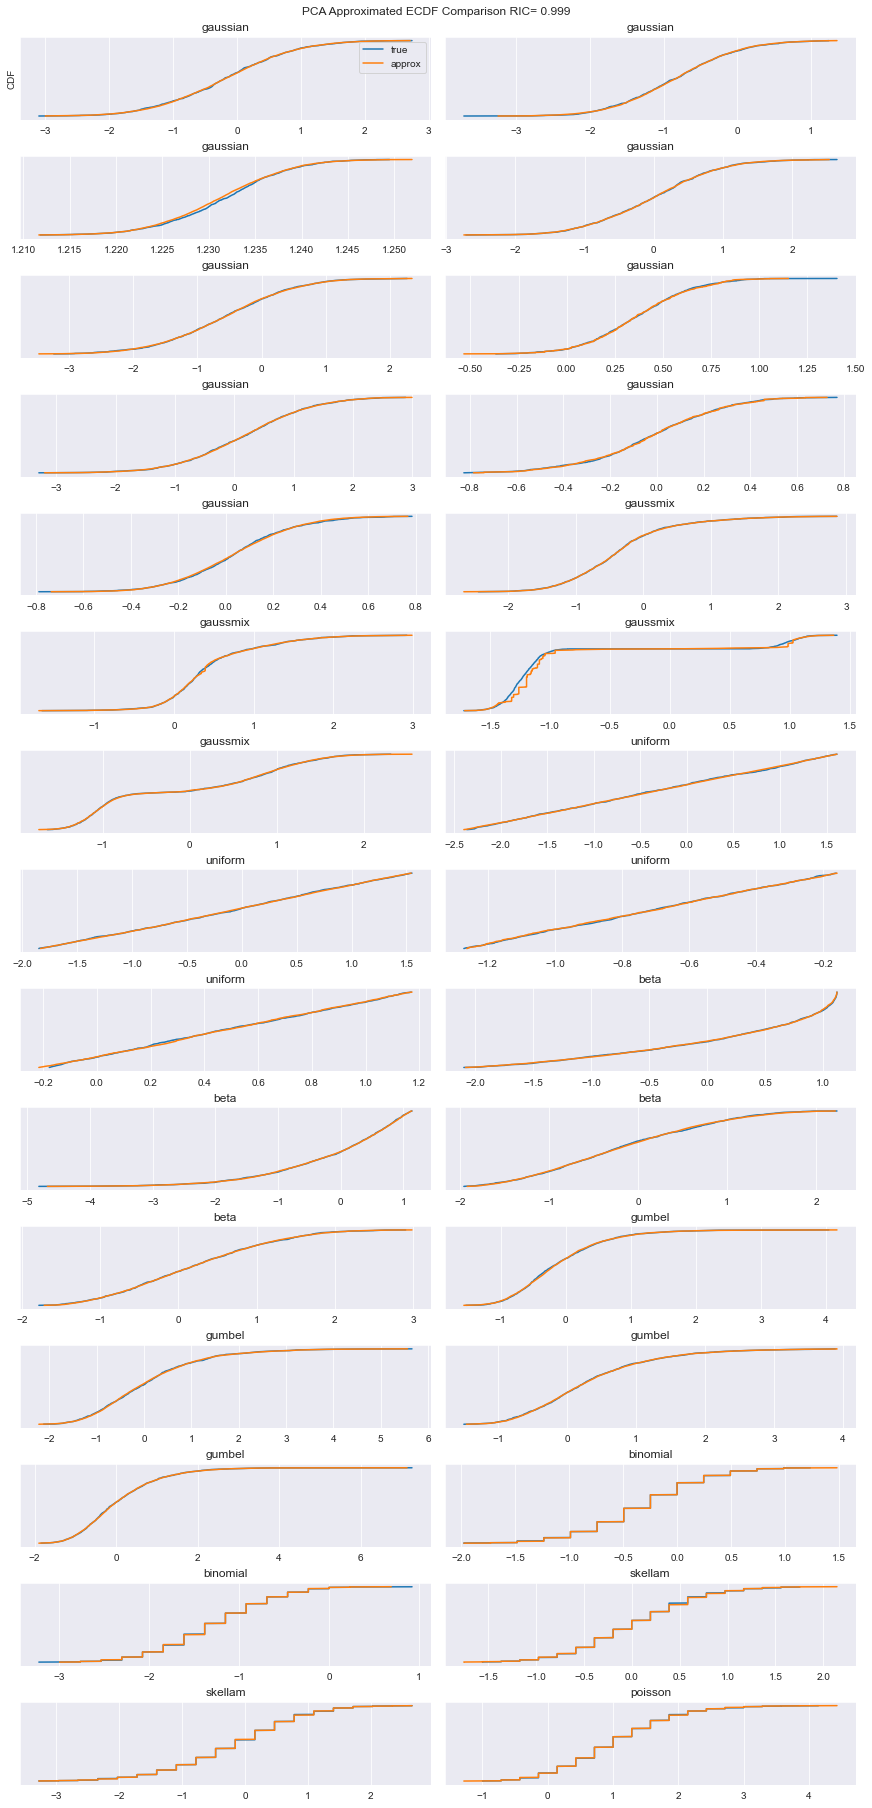

In [26]:
# comparison of true and OR approximated distributions for selected case
jj = 2
ecdf_y_, ecdfx_or = pca_sweep_data[jj].scaled_ecdfs
ecdf_y_, ecdfx_true = pca_sweep_data[-1].scaled_ecdfs
cur_ric = rics[jj]

case_to_plot = 0
fig6, ax6 = plt.subplots(15, 2, figsize=(12,25), constrained_layout=True)
ax = ax6.ravel()
for i in range(30):
    ax[i].plot(ecdfx_true[case_to_plot,:,i], ecdf_y_)
    ax[i].plot(ecdfx_or[case_to_plot,:,i], ecdf_y_)
    ax[i].set_title(parametric_experiment.simulations[0].distribution_types[i])
    ax[i].set_yticks(())
ax[0].set_ylabel("CDF")
ax[0].legend(['true', 'approx'], loc='best')
fig6.suptitle('PCA Approximated ECDF Comparison RIC= '+str(cur_ric))
plot_title = 'Case ' + str(case_to_plot) + ' comparison for PCA Approximated ECDF Comparison RIC= '+str(cur_ric)
fig6.savefig(datasavedir + '/' + plot_title + '.png')

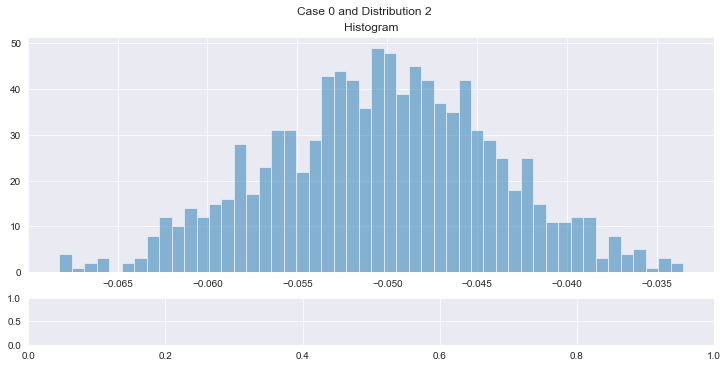

In [28]:
# plot true histogram example
case_to_plot = 0
dist_to_plot = 2
title = "Case " + str(case_to_plot) + " and Distribution " + str(dist_to_plot)
# plot example of epdf structure
fig22, ax22 = plt.subplots(2,1, figsize=(10,5), constrained_layout=True, gridspec_kw={'height_ratios':[5,1]})
ax = ax22.ravel()
center = ( (epdf_global_bins[dist_to_plot][:-1] + epdf_global_bins[dist_to_plot][1:])/2.0 )[:,0]
width = (epdf_global_bins[dist_to_plot][1] - epdf_global_bins[dist_to_plot][0])*0.8
ax[0].hist(raw_data[case_to_plot,:,dist_to_plot], bins=50, alpha=0.5)
ax[0].set_title("Histogram")
plt.suptitle(title)
plot_title = 'Case ' + str(case_to_plot) + ' Distribution ' + str(dist_to_plot) + ' True samples histogram'
fig22.savefig(datasavedir + '/' + plot_title + '.png')